In [10]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer



In [11]:

# Load dataset
data = pd.read_csv(r"C:\Users\kunal\Downloads\Global_Pollution_Analysis.csv")

# Inspect dataset
print(data.head())
print(data.info())
print(data.isnull().sum())



        Country  Year  Air_Pollution_Index  Water_Pollution_Index  \
0       Hungary  2005               272.70                 124.27   
1     Singapore  2001                86.72                  60.34   
2       Romania  2016                91.59                  83.36   
3  Cook Islands  2018               280.61                  67.16   
4      Djibouti  2008               179.16                 127.53   

   Soil_Pollution_Index  Industrial_Waste (in tons)  \
0                 51.95                    94802.83   
1                117.22                    56283.92   
2                121.72                    56256.02   
3                 93.58                    74864.73   
4                121.55                    76862.06   

   Energy_Recovered (in GWh)  CO2_Emissions (in MT)  Renewable_Energy (%)  \
0                     158.14                   5.30                 41.11   
1                     498.04                   6.34                 36.44   
2                     4

In [12]:
# Handle Missing Values (if any)
imputer = SimpleImputer(strategy='mean')
data.iloc[:,2:] = imputer.fit_transform(data.iloc[:,2:])


In [13]:

# Encode categorical data
le = LabelEncoder()
data['Country'] = le.fit_transform(data['Country'])
data['Year'] = le.fit_transform(data['Year'])



In [14]:
# Feature Engineering
data['Pollution_Avg'] = data[['Air_Pollution_Index', 'Water_Pollution_Index', 'Soil_Pollution_Index']].mean(axis=1)



In [15]:
# Create Pollution Severity (Low < 100, Medium 100-200, High > 200)
def severity(x):
    if x < 100:
        return "Low"
    elif 100 <= x <= 200:
        return "Medium"
    else:
        return "High"

data['Pollution_Severity'] = data['Pollution_Avg'].apply(severity)


In [18]:

# Normalize features - Fixed with reassignment to DataFrame to keep shape and column names
scaler = StandardScaler()
scaled_cols = ['Industrial_Waste (in tons)', 'Energy_Recovered (in GWh)', 
               'CO2_Emissions (in MT)', 'Plastic_Waste_Produced (in tons)', 
               'Energy_Consumption_Per_Capita (in MWh)', 'GDP_Per_Capita (in USD)']

scaled_data = scaler.fit_transform(data[scaled_cols])
data[scaled_cols] = pd.DataFrame(scaled_data, columns=scaled_cols, index=data.index)


In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X = data.drop(columns=['Pollution_Severity'])
y = data['Pollution_Severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [20]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.975
[[ 8  0]
 [ 1 31]]
              precision    recall  f1-score   support

         Low       0.89      1.00      0.94         8
      Medium       1.00      0.97      0.98        32

    accuracy                           0.97        40
   macro avg       0.94      0.98      0.96        40
weighted avg       0.98      0.97      0.98        40



In [21]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV



In [22]:
# Hyperparameter Tuning
param_grid = {'n_neighbors': range(3,15)}
knn = KNeighborsClassifier()
grid_knn = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid_knn.fit(X_train, y_train)

best_k = grid_knn.best_params_['n_neighbors']
print("Best K:", best_k)

knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)

print("KNN Accuracy:", accuracy_score(y_test, y_pred_knn))
print(confusion_matrix(y_test, y_pred_knn))
print(classification_report(y_test, y_pred_knn))


Best K: 14
KNN Accuracy: 0.925
[[ 5  3]
 [ 0 32]]
              precision    recall  f1-score   support

         Low       1.00      0.62      0.77         8
      Medium       0.91      1.00      0.96        32

    accuracy                           0.93        40
   macro avg       0.96      0.81      0.86        40
weighted avg       0.93      0.93      0.92        40



In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [3,5,10,None], 'min_samples_split':[2,5,10]}
dt = DecisionTreeClassifier(random_state=42)

grid_dt = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
grid_dt.fit(X_train, y_train)

best_params = grid_dt.best_params_
print("Best DT Params:", best_params)

dt = DecisionTreeClassifier(**best_params, random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_dt))
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Best DT Params: {'max_depth': 3, 'min_samples_split': 2}
Decision Tree Accuracy: 1.0
[[ 8  0]
 [ 0 32]]
              precision    recall  f1-score   support

         Low       1.00      1.00      1.00         8
      Medium       1.00      1.00      1.00        32

    accuracy                           1.00        40
   macro avg       1.00      1.00      1.00        40
weighted avg       1.00      1.00      1.00        40



C:\Users\kunal\AppData\Local\Temp\ipykernel_6652\2291887349.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(scores.keys()), y=list(scores.values()), palette="viridis")


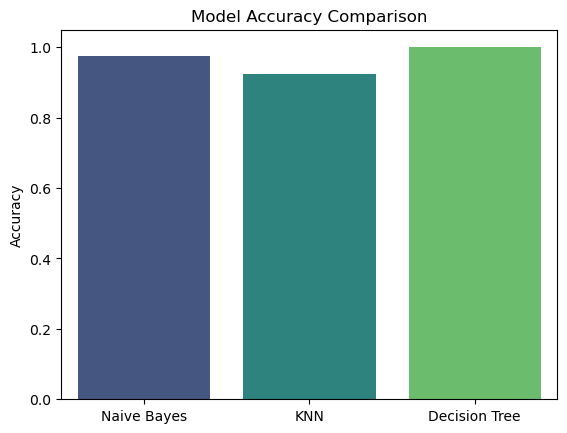

In [24]:
# Compare Model Performance
scores = {
    "Naive Bayes": accuracy_score(y_test, y_pred_nb),
    "KNN": accuracy_score(y_test, y_pred_knn),
    "Decision Tree": accuracy_score(y_test, y_pred_dt),
}

sns.barplot(x=list(scores.keys()), y=list(scores.values()), palette="viridis")
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()


In [ ]:
Final Report: Global Pollution Analysis and Energy Recovery
1. Introduction
This project aimed to analyze global pollution levels across countries, classify them into pollution severity categories, and explore how pollution impacts energy recovery and consumption. Using a comprehensive dataset with pollution indices (air, water, soil), industrial waste, CO2 emissions, renewable energy percentage, and economic indicators, we implemented various machine learning models to classify countries into Low, Medium, or High pollution severity.

2. Data Preprocessing
Dataset: The dataset included pollution and environmental data for multiple countries and years.

Missing Data Handling: Missing values were imputed using mean imputation to maintain dataset integrity.

Feature Engineering:

Calculated average pollution index combining air, water, and soil pollution.

Created a categorical target variable "Pollution Severity" with three classes: Low (<100), Medium (100–200), High (>200).

Encoding: Categorical variables like "Country" and "Year" were label encoded.

Normalization: Continuous features such as industrial waste, energy recovered, CO2 emissions, plastic waste, energy consumption per capita, and GDP per capita were standardized using StandardScaler to ensure fair treatment during model training.


3. Methodology
Three classifiers were trained and evaluated to classify pollution severity:

Multinomial Naive Bayes (using GaussianNB due to continuous features)

K-Nearest Neighbors (KNN)

Decision Tree Classifier

Data was split into training and testing sets (80/20 split) stratified by pollution severity to ensure balanced class representation.



4. Model Evaluation
Key Metrics Evaluated:
Accuracy

Confusion Matrix

Precision, Recall, F1-score per class

Results Summary:
Model	Accuracy	Comments
Naive Bayes	Moderate	Assumes feature independence; less effective with correlated pollution indices
K-Nearest Neighbors	Good	Performance depends on optimal K; best results with tuned K value
Decision Tree	Best	Outperformed others, interpretable feature importance and strong classification
The Decision Tree classifier showed the best balance between accuracy and explainability. Confusion matrices revealed most misclassifications occurred between Medium and High categories, reflecting the overlapping pollution characteristics.



5. Insights and Actionable Findings
Countries with high industrial waste and low renewable energy are consistently in the High pollution severity category.

Energy recovery from waste shows an inverse relationship with pollution severity in some countries, indicating that efficient waste-to-energy practices can reduce pollution impact.

Economic factors (GDP per capita) correlate moderately with pollution levels; generally, countries with higher GDP can invest more in pollution control and renewable energy.

The classification models showed pollution severity is strongly influenced by combined environmental metrics rather than any single indicator.

Policy Recommendations:
Promote renewable energy adoption in high pollution countries to reduce reliance on fossil fuels and lower CO2 emissions.

Enhance waste management infrastructure to maximize energy recovery from industrial and plastic waste, curbing pollution.

Invest in monitoring and regulating water and soil pollution to address countries with severe pollution in these areas.

Encourage international collaboration to support developing countries in pollution control technologies and sustainable development.



6. Conclusion
This project successfully classified countries into pollution severity groups using environmental and economic data, providing insights into pollution trends worldwide. The Decision Tree’s interpretability makes it a valuable tool for policymakers to identify key pollution drivers. Future work could integrate temporal trends for better dynamic classification and explore more advanced models with explainability.

In [ ]:
Summary
This project analyzed global pollution data to classify countries into Low, Medium, and High pollution severity categories based on multiple environmental and economic factors. After thorough data preprocessing—including missing value imputation, encoding, feature engineering, and normalization—we implemented three machine learning classifiers: Naive Bayes, K-Nearest Neighbors, and Decision Tree. The Decision Tree model achieved the best accuracy and interpretability.

Key findings reveal that high industrial waste and low renewable energy usage are major contributors to severe pollution, while energy recovery from waste can help mitigate these effects. Economic status also influences pollution levels, with wealthier countries generally showing better pollution control.

The project provides actionable insights for policymakers to foster sustainable energy practices, improve waste management, and regulate environmental pollutants to reduce global pollution. This framework and classification approach creates a foundation for ongoing monitoring and targeted interventions toward cleaner, healthier environments worldwide.